In [1]:
#1. IMPORTING PACKAGES AND LIBRARIES
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa
from cycler import cycler
import scipy
import seaborn as sns

import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd
import pickle
from scipy.signal import savgol_filter
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot


#own libary
import nsidc 

from functions_pmrs import loadCM
from functions_pmrs import applyshift
from functions_pmrs import calculateQR
from functions_pmrs import probability


In [361]:
#SELECT BOUNDS AND START / END DATES
bounds = [( -19., 20.),
          (-11., 27.),
         ]

# start_date = datetim.datetime(2002, 5, 29) # Start of the AMSR-E period
# start_date = datetime.datetime(2004, 1, 1) # date after data recovery
# end_date = datetime.datetime(2009, 12, 31)  # only a few days to make a demonstration
# end_date = datetime.datetime(2004, 6, 30)  # use this end date to cover the whole AMSR-E period.
# end_date = datetime.datetime(2002, 1, 2)

#---------------------------#---------------------------#---------------------------#---------------------------#

#Select set of POI's to use

# points = pd.read_csv('poizambeziplain.csv')   #Kalabo (weinig goede resultaten)
# points = pd.read_csv('poi_senaga.csv')
points = pd.read_csv('POIs_RE_3p.csv')


#adjust according to number of points in POI's
points_interest = [(points.xcoord[0],points.ycoord[0]),
                   (points.xcoord[1],points.ycoord[1])]
#                    (points.xcoord[2],points.ycoord[2]),
#                    (points.xcoord[3],points.ycoord[3]),
#                    (points.xcoord[4],points.ycoord[4])]
#                    (points.xcoord[5],points.ycoord[5])]
#                    (points.xcoord[6],points.ycoord[6]) 


# Download discharge data, no adjustment 
# dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',parse_dates=['DATE'],index_col = ['DATE'],na_filter=True)
dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',na_filter=True) #,parse_dates=['DATE'],index_col = ['DATE']
dQ['Date'] = pd.to_datetime(dQ['Date'])



#---------------------------#---------------------------#---------------------------#---------------------------#

# DOWNLOAD THE CORRECT DATA
# This cell calls the right download and "glues" the years together. 

fns=None

year = 2009  #change year to select specific year to see [2002-2011]

# 25 km resolution PMSR DATA
# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/*.nc') # select this line to get the whole AMSR-E period

# 3.125 km resolution PMSR DATA

# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/*.nc') # select this line to get the whole AMSR-E period

fns.sort()
ds = xr.open_mfdataset(fns[0:10])

#---------------------------#---------------------------#---------------------------#---------------------------#

# Discharge data location
# location = 'Kalabo'  
# location = 'Senanga'
location = 'Lukulu'


#---------------------------#---------------------------#---------------------------#---------------------------#


# TRANSFORMING, NO ADJUSTMENT NEEDED
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
bounds_xy = nsidc.proj_coords(bounds, proj_out, proj_in)
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)
points_x, points_y = zip(*points_xy)

#---------------------------#---------------------------#---------------------------#---------------------------#
sns.set()

<ipython-input-361-524d3c077ad3>:59: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fns[0:10])
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/xarray/backends/api.py:926: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pyproj/crs.py

In [362]:

shift=15
rollingvalue =6
selection= 5 # < number of months to be choosen
plot = 0
# month = 5 


In [288]:
df = loadCM(points_xy,ds, rollingvalue)
df = applyshift(df,rollingvalue,shift,plot)
fits,res = calculateQR(df,selection,plot,shift)
pred = probability(df, fits, plot, shift,location)

obs = df.POI4.values.copy()
threshold =1.05

/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


## Function to compute confusion matrix (hits, false alarms, misses, correct negatives) and performance indexes (FAR, POD, POFD, CSI))



Methodology adapted taking into account the consecutive day above thresholds as a unique flood period

hits:              Number of peak period above thresholds that have at least one observation day within the period

false alarm :      number of peak above threshold(consecutive day above discharge threshold as an event), minus the number of hits

misses :           number of observed flood events no in a discharge peak period  above threshold

correct negative : forcing the correct negative number to be the same than the number of observed flood events (misses + hits)



In [289]:
def calc_performance_scores(obs, pred, threshold):

 
    for i in range(len(obs)):
        if obs[i] > threshold:
            obs[i] =1
        else:
            obs[i]=0
            
    for j in range(len(pred)):
        if pred[j] > threshold:
            pred[j] =1
        else:
            pred[j]=0

#     print(obs)
#     print(pred) 

    
    
    hits = len(np.where((obs==1) & (pred ==1))[0])
    false_al = len(np.where((obs==0) & (pred ==1))[0])
    misses = len(np.where((obs==1) & (pred ==0))[0])
    corr_neg = len(np.where((obs==0) & (pred ==0))[0])
    
#     print((hits))
#     print((misses))
#     print((false_al))
#     print((corr_neg))

    output = np.zeros((4,))
    output[0] = hits / (hits + misses) #Probability of Detection
    output[1] = false_al / (hits + false_al) #False Alarm Rate
    output[2] = false_al / (false_al + corr_neg) #Probability of fase detection
    output[3] = hits / (hits + false_al + misses) #Critical succes index


    return output


#     df= pd.DataFrame({'cons_class': pred.diff().ne(0).cumsum(), 'hits':(obs==1) & (pred ==1)})
#     hits= df[['cons_class','hits' ]].drop_duplicates().hits[df.hits == True].count()
#     false_al = (pred.loc[pred.shift() != pred].sum ()) - hits 
#     misses = sum((obs == 1) & (pred ==0))
#     corr_neg = misses + hits


#     output = {}
#     output['pod'] = hits / (hits + misses) #Probability of Detection
#     output['far'] = false_al / (hits + false_al) #False Alarm Rate
#     output['pofd'] = false_al / (false_al + corr_neg) #Probability of fase detection
#     output['csi'] = hits / (hits + false_al + misses) #Critical succes index
#output=pd.Series(output)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
900
5
432
1585


Text(0.5, 0, 'False Alarm Rate [-]')

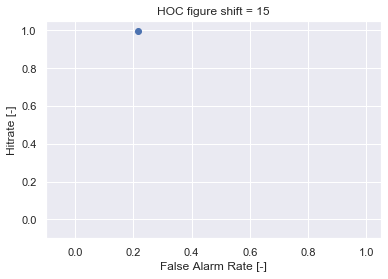

In [290]:
output = calc_performance_scores(obs,pred[4],threshold)


plt.plot(output[2],output[0],'-o',color ='b')
plt.xlim([-0.1,1.05])
plt.ylim([-0.1,1.05])
plt.title(f'HOC figure shift = {shift}')
plt.ylabel('Hitrate [-]')
plt.xlabel('False Alarm Rate [-]')

In [291]:
df = loadCM(points_xy,ds, rollingvalue)
df = applyshift(df,rollingvalue,shift,plot)
fits,res = calculateQR(df,selection,plot,shift)
pred = probability(df, fits, plot, shift,location)

obs = df.POI4.values.copy()
# threshold =1

/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
384
544
27
1967


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
520
408
75
1919


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
638
290
254
1740


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
749
179
736
1258


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
846
82
1373
621
[[0.4137931  0.06569343 0.01354062 0.40209424]
 [0.56034483 0.12605042 0.03761284 0.51844467]
 [0.6875     0.28475336 0.12738215 0.53976311]
 [0.80711207 0.4956229  0.36910732 0.45012019]
 [0.91163793 0.61874718 0.6885657  0.36766623]]


Text(0.5, 0, 'Prob. of False Alarm [-]')

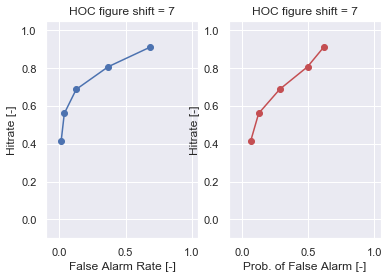

In [364]:
HOC =np.zeros((5,4))
threshold =1.0
shift=7

for n in range (5):
    df = loadCM(points_xy,ds, rollingvalue)
    df = applyshift(df,rollingvalue,shift,plot)
    fits,res = calculateQR(df,selection,plot,shift)
    pred = probability(df, fits, plot, shift,location)
    obs = df.POI4.values.copy()
    
    output = calc_performance_scores(obs,pred[n],threshold)
#     print(output)
    HOC [n]= output
print(HOC)

# # plt.scatter(HOC[1,:],HOC[0,:],color='g')
# # plt.scatter(HOC[2,:],HOC[0,:],color ='r')
plt.figure()


plt.subplot(1,2,1)
plt.plot(HOC[:,2],HOC[:,0],'-o',color ='b')
plt.xlim([-0.1,1.05])
plt.ylim([-0.1,1.05])
plt.title(f'HOC figure shift = {shift}')
plt.ylabel('Hitrate [-]')
plt.xlabel('False Alarm Rate [-]')

plt.subplot(1,2,2)
plt.plot(HOC[:,1],HOC[:,0],'-o',color ='r')
plt.xlim([-0.1,1.05])
plt.ylim([-0.1,1.05])
plt.title(f'HOC figure shift = {shift}')
plt.ylabel('Hitrate [-]')
plt.xlabel('Prob. of False Alarm [-]')



/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 0.]
275
653
24
1970
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 0.]
489
439
73
1921
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 0.]
606
322
223
1771
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
737
191
556
1438
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
831
97
1224
770


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
291
637
27
1967
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
494
434
76
1918
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
609
319
220
1774
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
734
194
573
1421
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
837
91
1336
658


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
295
633
23
1971
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
503
425
80
1914
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
614
314
221
1773
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
733
195
579
1415
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
840
88
1356
638


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
308
620
20
1974
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
511
417
79
1915
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
620
308
229
1765
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
731
197
581
1413
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
854
74
1408
586


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
335
593
22
1972
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
515
413
83
1911
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
623
305
236
1758
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
731
197
591
1403
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
854
74
1405
589


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
343
585
22
1972
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
516
412
83
1911
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
627
301
242
1752
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
733
195
595
1399
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
855
73
1404
590


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
374
554
25
1969
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
518
410
83
1911
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
629
299
246
1748
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
745
183
700
1294
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
853
75
1403
591


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
384
544
27
1967
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
520
408
75
1919
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
638
290
254
1740
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
749
179
736
1258
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
846
82
1373
621


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
394
534
23
1971
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
523
405
73
1921
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
642
286
256
1738
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
749
179
757
1237
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
849
79
1388
606


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
396
532
20
1974
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
526
402
69
1925
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
646
282
255
1739
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
757
171
793
1201
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
851
77
1406
588


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
398
530
20
1974
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
527
401
67
1927
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
645
283
258
1736
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
764
164
885
1109
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
850
78
1418
576


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
398
530
21
1973
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
528
400
70
1924
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
643
285
277
1717
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
765
163
955
1039
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
861
67
1463
531


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
398
530
18
1976
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
532
396
79
1915
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
642
286
290
1704
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
777
151
1030
964
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
862
66
1473
521


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 1. 1.]
400
528
20
1974
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
530
398
83
1911
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
648
280
301
1693
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
778
150
1065
929
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
867
61
1538
456


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 1.]
395
533
19
1975
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 1. 1.]
534
394
88
1906
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
656
272
311
1683
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
792
136
1130
864
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
862
66
1567
427


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
391
537
22
1972
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 1.]
534
394
93
1901
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 1. 1.]
658
270
318
1676
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
797
131
1160
834
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
859
69
1573
421


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
387
541
28
1966
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
530
398
96
1898
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 1.]
665
263
319
1675
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
800
128
1156
838
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
857
71
1582
412


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
377
551
26
1968
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
539
389
108
1886
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
668
260
334
1660
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
801
127
1165
829
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
860
68
1611
383


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
375
553
28
1966
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
535
393
120
1874
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
665
263
337
1657
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
809
119
1247
747
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
861
67
1612
382


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
370
558
30
1964
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
531
397
134
1860
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
664
264
350
1644
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 0. 1. 1.]
827
101
1312
682
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
868
60
1650
344


<ipython-input-366-fd014e5dab11>:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


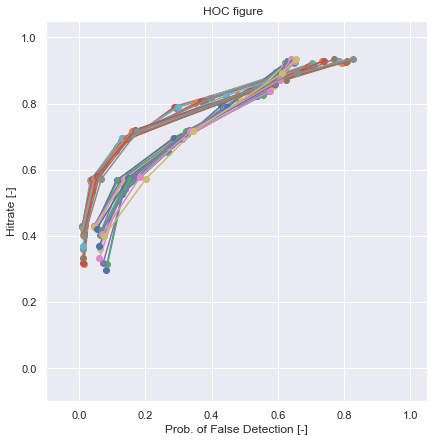

In [366]:
# Run the HOC figures over all the shift positions
HOC =np.zeros((20,5,4))
threshold =1.0

for i, n in enumerate(range(0, 20, 1)):
    shift = n
    df = loadCM(points_xy,ds, rollingvalue)
    df = applyshift(df,rollingvalue,shift,plot)
    fits,res = calculateQR(df,selection,plot,shift)
    pred = probability(df, fits, plot, shift,location)
    obs = df.POI4.values.copy()
    

    for j in range (5):
        output = calc_performance_scores(obs,pred[j],threshold)
        pred = probability(df, fits, plot, shift,location)
        obs = df.POI4.values.copy()
        HOC [i, j]= output
# HOC

plt.figure(figsize=(15,15))
for n in range (20):

    plt.plot(HOC[n,:,2],HOC[n,:,0],'-o') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('False Alarm Rate [-]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()

    plt.subplot(1,2,2)
    plt.plot(HOC[n,:,1],HOC[n,:,0],'-o')#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure  ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()

<ipython-input-367-51427633ffcc>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-367-51427633ffcc>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


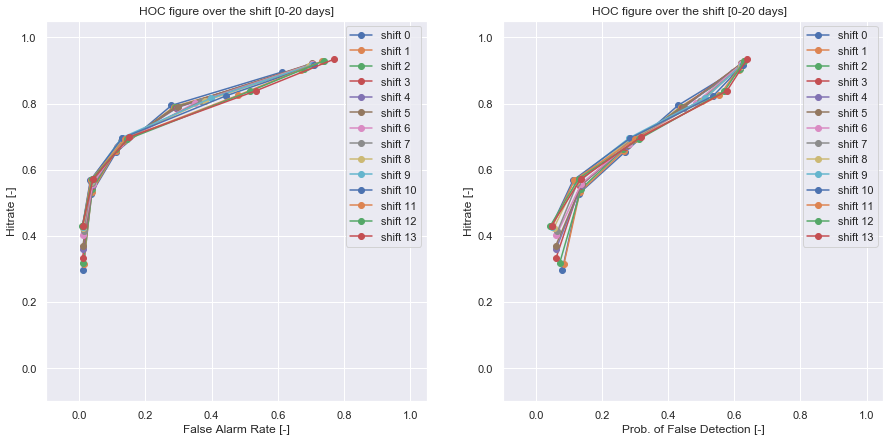

In [367]:
plt.figure(figsize=(15,15))
for n in range (14):

    plt.subplot(1,2,1)
    plt.plot(HOC[n,:,2],HOC[n,:,0],'-o',label=f'shift {n}') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over the shift [0-20 days]')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('False Alarm Rate [-]')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()

    plt.subplot(1,2,2)
    plt.plot(HOC[n,:,1],HOC[n,:,0],'-o',label=f'shift {n}')#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over the shift [0-20 days]  ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()
        
plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/HOC_Shift{location}.png'),dpi=600)


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
1787
1121
2
12
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
2359
549
3
11
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
2775
133
7
7
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
2893
15
7
7
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
2895
13
8
6


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[1. 1. 1. ... 1. 1. 1.]
[0. 0. 0. ... 1. 1. 1.]
773
1911
15
223
[1. 1. 1. ... 1. 1. 1.]
[0. 0. 0. ... 1. 1. 1.]
941
1743
38
200
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
1673
1011
76
162
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
2450
234
173
65
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
2616
68
206
32


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
384
544
27
1967
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
520
408
75
1919
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
638
290
254
1740
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
749
179
736
1258
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
846
82
1373
621


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
117
307
5
2493
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
220
204
24
2474
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
359
65
219
2279
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
383
41
474
2024
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
401
23
639
1859


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
11
246
0
2665
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
69
188
5
2660
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
198
59
77
2588
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
248
9
319
2346
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
249
8
472
2193


<ipython-input-378-cf496bff9138>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-378-cf496bff9138>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


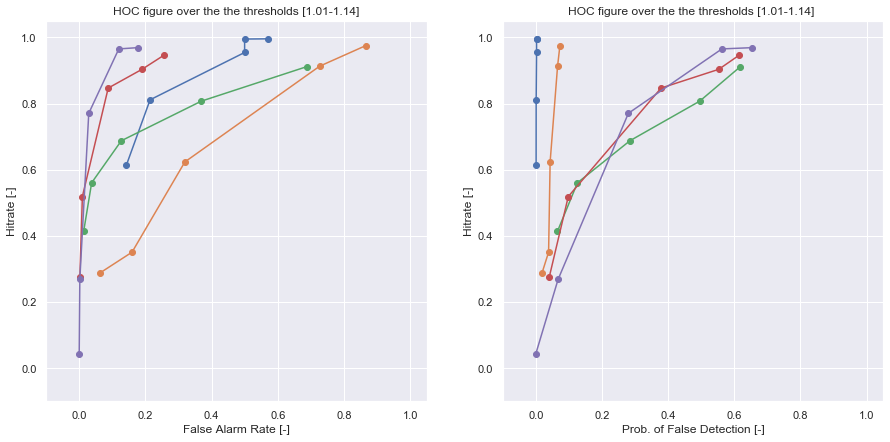

In [378]:
# Run the HOC figures over the threshold bounds
HOC =np.zeros((5,5,4))
shift =7
for i, n in enumerate([ 0.98, 0.99, 1, 1.01,1.02]):#,1.03,1.04,1.05]):#, 1.06,1.07, 1.08, 1.09 ,1.10, 1.11,1.12,1.13,1.14]):
    threshold = n
    df = loadCM(points_xy,ds, rollingvalue)
    df = applyshift(df,rollingvalue,shift,plot)
    fits,res = calculateQR(df,selection,plot,shift)
    pred = probability(df, fits, plot, shift, location)
    obs = df.POI4.values.copy()
    
    for j in range (5):
        output = calc_performance_scores(obs,pred[j],threshold)
        pred = probability(df, fits, plot, shift,location)
        obs = df.POI4.values.copy()
        HOC [i, j]= output
#         output =calc_performance_scores(obs,pred[j],threshold)
# HOC


plt.figure(figsize=(15,15))

for n in range (5):

    plt.subplot(1,2,1)
    plt.plot(HOC[n,:,2],HOC[n,:,0],'-o') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over the the thresholds [1.01-1.14]')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('False Alarm Rate [-]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()


    plt.subplot(1,2,2)
    plt.plot(HOC[n,:,1],HOC[n,:,0],'-o')#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over the the thresholds [1.01-1.14] ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()  

<ipython-input-384-9dfb5fe6ad2a>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-384-9dfb5fe6ad2a>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


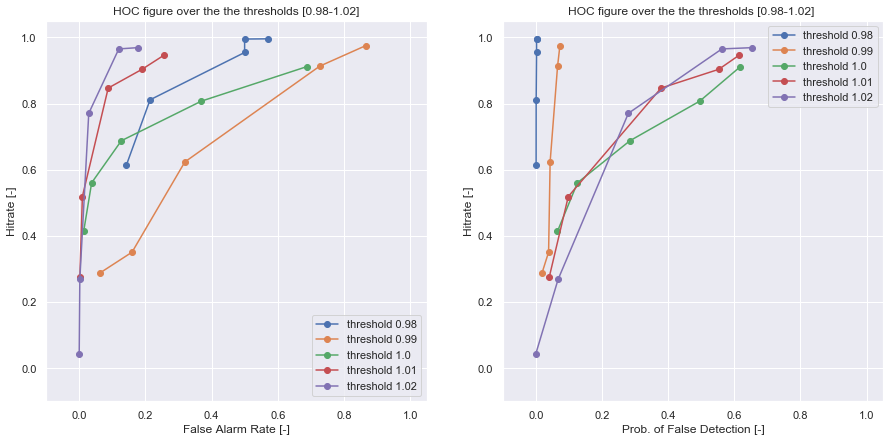

In [384]:
plt.figure(figsize=(15,15))

for n in range (5):

    plt.subplot(1,2,1)
    plt.plot(HOC[n,:,2],HOC[n,:,0],'-o',label=f'threshold {0.98+n*0.01}') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over the the thresholds [0.98-1.02]')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('False Alarm Rate [-]')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()


    plt.subplot(1,2,2)
    plt.plot(HOC[n,:,1],HOC[n,:,0],'-o',label=f'threshold {0.98+n*0.01}')#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over the the thresholds [0.98-1.02] ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.draw()  
    plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/HOC_threshold{location}.png'),dpi=600)
